In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.metrics import mse, rmse, r2_score, mae, smape, wmape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, facet_grid
)
import json


torch.set_float32_matmul_precision('medium')


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity',
    'Soil_Moisture', 'Soil_Temperature'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_mse = float('inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

# Listas para armazenar dados de todos os folds
all_forecasts = []
all_val_scaled = []
all_scalers = []
all_metrics_dfs = []
all_mse_scores = []
all_train_scaled = []
all_metrics_horizon = []

tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = BlockRNNModel(
        model="LSTM",
        model_name=f"model_{fold+1}",
        input_chunk_length=24,
        output_chunk_length=24,
        hidden_dim=256,
        n_rnn_layers=2,
        n_epochs=100,
        batch_size=112,
        dropout=0.5,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.L1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr":  0.0023152837587172353, "weight_decay": 0.0001372149130909975
},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )

    model.load_from_checkpoint(f"model_{fold+1}/", best=True)

    metrics_per_horizon = []
    for i in [1,4,8,12,16,20,24]:
        forecasts = model.historical_forecasts(
            val_scaled,
            forecast_horizon=i,
            stride=1,
            retrain=False,
            verbose=False,
            last_points_only=True,
        )

        forecasts_t = scaler.inverse_transform(forecasts)
        s = scaler.inverse_transform(val_scaled)
        metrics = {}
        print("Iniciando a verificação das séries temporais para constância...")
        try:
            for target in target_columns:
                metrics[target] = {
                    'MSE': mse(s[target], forecasts_t[target]),
                    'RMSE': rmse(s[target], forecasts_t[target]),
                    'MAE': mae(s[target], forecasts_t[target]),
                    'R2': r2_score(s[target], forecasts_t[target]),
                    'SMAPE': smape(s[target], forecasts_t[target]),
                    'WMAPE': wmape(s[target], forecasts_t[target]),
                }
            metrics_df = pd.DataFrame(metrics).T
            print("\nMétricas de performance:")
            print(metrics_df)
            metrics_per_horizon.append(metrics_df)
        except Exception as e:
            print(e)

    mse_geral = mse(s, forecasts_t)
    print(f"O MSE desse fold foi {mse_geral}")

    # Armazenar dados deste fold
    all_forecasts.append(forecasts)
    all_val_scaled.append(val_scaled)
    all_scalers.append(scaler)
    all_metrics_dfs.append(metrics_df)
    all_metrics_horizon.append(metrics_per_horizon)
    all_mse_scores.append(mse_geral)
    all_train_scaled.append(train_scaled)

    # Ainda mantemos o melhor fold para referência (agora baseado no MSE)
    if best_mse > mse_geral:
        best_mse = mse_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold (baseado no menor MSE) foi {best_fold}")

# Calcular a média dos R2 e MSE de todos os folds
avg_mse = sum(all_mse_scores) / len(all_mse_scores)
print(f"A média dos MSE de todos os folds foi {avg_mse:.4f}")

avg_metrics = {}
metric_names = ['MSE', 'RMSE', 'MAE', 'R2', 'SMAPE', 'WMAPE'] # Definir nomes das métricas

for target in target_columns:
    avg_metrics[target] = {} # Inicializar dicionário para o target atual
    for metric_name in metric_names:
        metric_values_for_fold = []
        # Coletar todos os valores válidos da métrica para o target atual em todos os folds
        for df_fold in all_metrics_dfs:
            # Verificar se o target existe como índice e a métrica como coluna no df_fold
            if target in df_fold.index and metric_name in df_fold.columns:
                value = df_fold.loc[target, metric_name]
                # Adicionar à lista apenas se não for NaN
                if pd.notna(value):
                    metric_values_for_fold.append(value)
        
        # Calcular a média apenas se houver valores válidos
        if metric_values_for_fold:
            avg_metrics[target][metric_name] = sum(metric_values_for_fold) / len(metric_values_for_fold)
        else:
            # Caso contrário, registrar NaN (ou outro valor padrão, se preferir)
            avg_metrics[target][metric_name] = float('nan')

avg_metrics_df = pd.DataFrame(avg_metrics).T
print("\nMétricas médias de performance de todos os folds:")
print(avg_metrics_df)


with open('all_metrics_horizon.json', 'w') as f:
    all_metrics_horizon_dict = [
        [df.to_dict() for df in fold_metrics] for fold_metrics in all_metrics_horizon
    ]
    json.dump(all_metrics_horizon_dict, f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

print("\nUsando a média dos folds para análise...")


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 10.056
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 10.051
Metric val_loss improved by 0.043 >= min_delta = 0.001. New best score: 10.007
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 10.005
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 10.002
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 9.998
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 9.986
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 9.977
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 9.970
Monitored metric val_loss did not improve in the last 10 records. Best score: 9.970. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/pyt

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE        R2  \
Temperature                7.467955e+01     8.641733    6.330812 -0.634107   
Precipitation_accumulated  5.808464e+04   241.007556  130.298124 -0.411389   
Humidity                   3.609814e+02    18.999511   13.865663 -0.203559   
Soil_Moisture              1.374822e+06  1172.527971  904.317265 -0.131479   
Soil_Temperature           1.016800e+02    10.083649    7.516542 -0.798966   

                               SMAPE      WMAPE  
Temperature                34.056236  38.314360  
Precipitation_accumulated  84.250758  97.882013  
Humidity                   19.723835  18.175644  
Soil_Moisture              11.517012  11.273784  
Soil_Temperature           38.767376  45.785192  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE        R2  \
Temperature                1.208346e+02    10.992481    7.957939 -1.640929   
Precipitation_accumulated  5.826505e+04   241.381548  130.665730 -0.413943   
Humidity                   6.917765e+02    26.301645   18.456522 -1.301608   
Soil_Moisture              1.458288e+06  1207.595962  924.246351 -0.198259   
Soil_Temperature           1.172253e+02    10.827064    8.009852 -1.071488   

                               SMAPE      WMAPE  
Temperature                38.943362  48.132166  
Precipitation_accumulated  85.197146  97.945891  
Humidity                   28.640795  24.196034  
Soil_Moisture              11.750169  11.524076  
Soil_Temperature           40.417488  48.756945  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE        R2  \
Temperature                6.288062e+01     7.929730    5.871091 -0.371870   
Precipitation_accumulated  5.840399e+04   241.669165  131.006048 -0.414873   
Humidity                   5.662122e+02    23.795214   17.001057 -0.881062   
Soil_Moisture              1.314224e+06  1146.395957  886.779445 -0.077573   
Soil_Temperature           8.749844e+01     9.354060    6.864379 -0.543127   

                               SMAPE      WMAPE  
Temperature                32.809548  35.483172  
Precipitation_accumulated  85.122810  97.917233  
Humidity                   25.594354  22.297269  
Soil_Moisture              11.318903  11.059269  
Soil_Temperature           36.483122  41.752144  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE        R2  \
Temperature                3.217200e+01     5.672037    4.492920  0.299302   
Precipitation_accumulated  5.858672e+04   242.046940  131.413502 -0.416853   
Humidity                   2.052235e+02    14.325624   11.031951  0.319981   
Soil_Moisture              1.336720e+06  1156.166148  891.018250 -0.094206   
Soil_Temperature           4.117529e+01     6.416798    4.944832  0.274035   

                               SMAPE      WMAPE  
Temperature                27.790986  27.170697  
Precipitation_accumulated  85.643517  97.937198  
Humidity                   15.412511  14.466995  
Soil_Moisture              11.373129  11.115144  
Soil_Temperature           29.710102  30.106265  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE        R2  \
Temperature                3.569283e+01     5.974348    4.765386  0.222298   
Precipitation_accumulated  5.869118e+04   242.262620  131.686695 -0.416932   
Humidity                   2.470216e+02    15.716919   11.925978  0.182836   
Soil_Moisture              1.472942e+06  1213.648423  929.975593 -0.204223   
Soil_Temperature           4.081505e+01     6.388666    4.983650  0.278871   

                               SMAPE      WMAPE  
Temperature                29.227945  28.855490  
Precipitation_accumulated  84.593076  97.855641  
Humidity                   16.656142  15.632500  
Soil_Moisture              11.826020  11.604745  
Soil_Temperature           30.195918  30.395714  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE        R2  \
Temperature                3.066800e+01     5.537870    4.501143  0.333116   
Precipitation_accumulated  5.892559e+04   242.745929  132.162105 -0.420138   
Humidity                   2.071677e+02    14.393323   11.053147  0.315425   
Soil_Moisture              1.548040e+06  1244.202619  950.508179 -0.264305   
Soil_Temperature           3.576022e+01     5.979985    4.720146  0.369723   

                               SMAPE      WMAPE  
Temperature                28.075769  27.258305  
Precipitation_accumulated  85.407102  97.922724  
Humidity                   15.337091  14.492026  
Soil_Moisture              12.062898  11.864897  
Soil_Temperature           28.779687  28.790127  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE        R2  \
Temperature                5.256757e+01     7.250350    5.634992 -0.141070   
Precipitation_accumulated  5.910280e+04   243.110678  132.553660 -0.421954   
Humidity                   4.313735e+02    20.769533   15.425206 -0.426396   
Soil_Moisture              1.369201e+06  1170.128804  906.770142 -0.117054   
Soil_Temperature           5.250438e+01     7.245991    5.763661  0.076555   

                               SMAPE      WMAPE  
Temperature                32.550165  34.098122  
Precipitation_accumulated  85.518235  97.925766  
Humidity                   22.365377  20.239563  
Soil_Moisture              11.563099  11.322677  
Soil_Temperature           33.425708  35.128889  
O MSE desse fold foi 285768.13288521586

Fold 2

Treinando o modelo...
Train set: 2773 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.376
Metric val_loss improved by 0.146 >= min_delta = 0.001. New best score: 0.230
Metric val_loss improved by 0.141 >= min_delta = 0.001. New best score: 0.089
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.083
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.083. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    31.549771    5.616918    4.866620   
Precipitation_accumulated      93.498732    9.669474    9.355746   
Humidity                      128.437047   11.333007    9.652465   
Soil_Moisture              525194.136974  724.702792  641.287934   
Soil_Temperature               37.367721    6.112914    5.469460   

                                     R2      SMAPE      WMAPE  
Temperature                   -2.611512  31.474281  30.988481  
Precipitation_accumulated -11452.694285   2.020268   2.042249  
Humidity                      -5.218672  11.233651  11.214662  
Soil_Moisture                -89.177039   9.474487  10.056777  
Soil_Temperature              -3.046866  39.141982  34.824314  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    32.984473    5.743211    4.999618    -2.806161   
Precipitation_accumulated      25.619571    5.061578    4.679005 -3243.101658   
Humidity                      144.709204   12.029514   10.104334    -5.997582   
Soil_Moisture              555302.011107  745.185890  655.989019   -94.626789   
Soil_Temperature               42.330934    6.506223    5.711659    -3.606591   

                               SMAPE      WMAPE  
Temperature                33.264220  31.863805  
Precipitation_accumulated   1.015492   1.021370  
Humidity                   12.032648  11.740550  
Soil_Moisture               9.673060  10.286907  
Soil_Temperature           40.018300  36.394141  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    33.275213    5.768467    4.976035    -2.876924   
Precipitation_accumulated      41.435996    6.437080    6.097292 -5495.275223   
Humidity                      143.117428   11.963170   10.047260    -5.913626   
Soil_Moisture              602798.869597  776.401230  685.169400  -103.238648   
Soil_Temperature               36.730264    6.060550    5.262227    -3.022838   

                               SMAPE      WMAPE  
Temperature                32.350932  31.749737  
Precipitation_accumulated   1.321178   1.330962  
Humidity                   11.965291  11.675709  
Soil_Moisture              10.076280  10.743913  
Soil_Temperature           36.635873  33.564443  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    31.906178    5.648555    4.883426    -2.748769   
Precipitation_accumulated      50.549619    7.109826    6.618095 -7043.091519   
Humidity                      128.090043   11.317687    9.659067    -5.181985   
Soil_Moisture              694109.661038  833.132439  745.346872  -119.464282   
Soil_Temperature               34.757503    5.895549    5.158959    -2.830164   

                               SMAPE      WMAPE  
Temperature                33.818049  31.192579  
Precipitation_accumulated   1.432767   1.444643  
Humidity                   11.091127  11.226055  
Soil_Moisture              10.917434  11.686922  
Soil_Temperature           36.057815  32.938637  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    29.982959    5.475670    4.520866    -2.549546   
Precipitation_accumulated      11.784358    3.432835    3.123798 -1729.711312   
Humidity                      112.377207   10.600812    8.664076    -4.416626   
Soil_Moisture              604723.413077  777.639642  698.801753  -104.253626   
Soil_Temperature               32.923431    5.737894    4.828994    -2.649251   

                               SMAPE      WMAPE  
Temperature                27.358008  28.906818  
Precipitation_accumulated   0.679212   0.681882  
Humidity                   10.397073  10.070835  
Soil_Moisture              10.285451  10.956559  
Soil_Temperature           31.137709  30.862185  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    27.611167    5.254633    4.524599    -2.298445   
Precipitation_accumulated      17.313973    4.161006    3.673440 -2688.654701   
Humidity                      105.722175   10.282129    8.791921    -4.086258   
Soil_Moisture              526923.779357  725.895157  638.624518   -91.029660   
Soil_Temperature               32.347156    5.687456    4.909544    -2.607834   

                               SMAPE      WMAPE  
Temperature                30.430977  28.962790  
Precipitation_accumulated   0.798416   0.801860  
Humidity                   10.150495  10.220412  
Soil_Moisture               9.433583  10.012516  
Soil_Temperature           33.213652  31.408529  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    29.109693    5.395340    4.582463    -2.516251   
Precipitation_accumulated      19.936506    4.465031    3.991756 -3288.336931   
Humidity                      101.631851   10.081262    8.695035    -3.883144   
Soil_Moisture              413172.032132  642.784592  564.527161   -71.513528   
Soil_Temperature               33.752307    5.809674    4.857412    -2.791532   

                               SMAPE      WMAPE  
Temperature                29.040613  29.368369  
Precipitation_accumulated   0.866764   0.871342  
Humidity                    9.996459  10.108979  
Soil_Moisture               8.399210   8.850292  
Soil_Temperature           30.419659  31.107737  
O MSE desse fold foi 82671.2924978779

Fold 3

Treinando o modelo...
Train set: 4157 samples
Validation set: 1384 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.101
Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.085
Metric val_loss improved by 0.053 >= min_delta = 0.001. New best score: 0.031
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.031. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU avai

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     6.805637    2.608762    2.475772  -10.074385   
Precipitation_accumulated      18.590265    4.311643    4.124256 -457.030435   
Humidity                       10.503386    3.240893    2.701434   -0.124313   
Soil_Moisture              268479.939826  518.150499  474.264123   -5.779020   
Soil_Temperature                4.200906    2.049611    1.934903  -17.276023   

                               SMAPE      WMAPE  
Temperature                23.666711  26.557216  
Precipitation_accumulated   0.904008   0.899667  
Humidity                    2.970331   2.966062  
Soil_Moisture               7.722338   7.975100  
Soil_Temperature           17.944471  19.709298  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     6.580079    2.565166    2.419431   -9.760190   
Precipitation_accumulated      11.486040    3.389106    3.278306 -282.158258   
Humidity                       10.683273    3.268528    2.718616   -0.141506   
Soil_Moisture              244158.835032  494.124311  450.099731   -5.222662   
Soil_Temperature                4.021269    2.005310    1.896254  -16.644305   

                               SMAPE      WMAPE  
Temperature                23.210583  25.961505  
Precipitation_accumulated   0.717810   0.715130  
Humidity                    2.989951   2.984832  
Soil_Moisture               7.346801   7.570034  
Soil_Temperature           17.645965  19.320200  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE         R2  \
Temperature                     4.880201    2.209118    2.046221  -7.052624   
Precipitation_accumulated       0.870908    0.933224    0.801974 -20.486953   
Humidity                       10.489703    3.238781    2.699297  -0.117688   
Soil_Moisture              212693.463386  461.187016  417.745972  -4.490981   
Soil_Temperature                2.751984    1.658910    1.545412 -11.264618   

                               SMAPE      WMAPE  
Temperature                20.023280  21.967720  
Precipitation_accumulated   0.174969   0.174943  
Humidity                    2.969283   2.963559  
Soil_Moisture               6.841286   7.027485  
Soil_Temperature           14.643704  15.751241  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE         R2  \
Temperature                     6.962050    2.638570    2.497689 -10.606530   
Precipitation_accumulated       3.580481    1.892216    1.701522 -87.409721   
Humidity                       11.675217    3.416902    2.833863  -0.240353   
Soil_Moisture              215737.130153  464.475113  421.058093  -4.644608   
Soil_Temperature                4.090771    2.022565    1.922846 -17.564350   

                               SMAPE      WMAPE  
Temperature                23.878340  26.828573  
Precipitation_accumulated   0.370349   0.371169  
Humidity                    3.112338   3.111274  
Soil_Moisture               6.894087   7.084829  
Soil_Temperature           17.890258  19.605590  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     7.530565    2.744188    2.599066  -11.681201   
Precipitation_accumulated      11.385415    3.374228    3.158826 -280.368610   
Humidity                       10.208453    3.195067    2.635662   -0.081349   
Soil_Moisture              220752.924676  469.843511  426.464229   -4.856223   
Soil_Temperature                5.188158    2.277753    2.187272  -22.960844   

                               SMAPE      WMAPE  
Temperature                24.719645  27.931914  
Precipitation_accumulated   0.691692   0.689064  
Humidity                    2.902436   2.893639  
Soil_Moisture               6.979789   7.177455  
Soil_Temperature           20.102125  22.310004  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     5.871891    2.423199    2.273109   -8.979906   
Precipitation_accumulated      15.876595    3.984544    3.826886 -391.703429   
Humidity                       11.749942    3.427819    2.830186   -0.241011   
Soil_Moisture              248769.505402  498.767988  455.031348   -5.691857   
Soil_Temperature                4.083960    2.020881    1.910348  -18.169238   

                               SMAPE      WMAPE  
Temperature                21.994171  24.441068  
Precipitation_accumulated   0.838498   0.834793  
Humidity                    3.108706   3.107158  
Soil_Moisture               7.427488   7.660013  
Soil_Temperature           17.777252  19.492357  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     4.168965    2.041804    1.873535   -6.145401   
Precipitation_accumulated      24.362447    4.935833    4.821126 -602.144673   
Humidity                       10.918325    3.304289    2.766250   -0.149887   
Soil_Moisture              242825.224347  492.772995  449.837255   -5.625290   
Soil_Temperature                2.288263    1.512700    1.374637   -9.899645   

                               SMAPE      WMAPE  
Temperature                18.531376  20.154414  
Precipitation_accumulated   1.057418   1.051674  
Humidity                    3.039323   3.036901  
Soil_Moisture               7.347360   7.574330  
Soil_Temperature           13.126543  14.030983  
O MSE desse fold foi 48573.39246919508

Fold 4

Treinando o modelo...
Train set: 5541 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.100
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.099
Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.087
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.087. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE         R2  \
Temperature                7.614507e+00     2.759440    2.307885  -0.416253   
Precipitation_accumulated  5.453165e+01     7.384555    7.099399 -44.631687   
Humidity                   1.521300e+02    12.334100   11.185553  -0.852035   
Soil_Moisture              1.558240e+06  1248.295005  771.347540  -0.148493   
Soil_Temperature           1.059475e+01     3.254957    2.647388  -0.744682   

                               SMAPE      WMAPE  
Temperature                41.962157  40.501542  
Precipitation_accumulated   1.555520   1.543300  
Humidity                   12.930430  13.285668  
Soil_Moisture              11.083168  11.831834  
Soil_Temperature           49.029356  47.710788  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE         R2  \
Temperature                9.849120e+00     3.138331    2.607860  -0.830565   
Precipitation_accumulated  3.804628e+01     6.168167    5.931530 -30.878507   
Humidity                   1.364236e+02    11.680051   10.744618  -0.657375   
Soil_Moisture              1.632808e+06  1277.813697  790.618070  -0.201998   
Soil_Temperature           1.687957e+01     4.108476    3.438626  -1.784891   

                               SMAPE      WMAPE  
Temperature                45.015101  45.799385  
Precipitation_accumulated   1.297759   1.289415  
Humidity                   12.457701  12.762681  
Soil_Moisture              11.396110  12.124210  
Soil_Temperature           56.409750  62.053166  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE         R2  \
Temperature                1.122424e+01     3.350260    2.792840  -1.082898   
Precipitation_accumulated  5.255614e+01     7.249562    6.866733 -43.114585   
Humidity                   1.428378e+02    11.951478   11.096634  -0.730387   
Soil_Moisture              1.709929e+06  1307.642354  808.767403  -0.256791   
Soil_Temperature           1.812920e+01     4.257840    3.551827  -1.997911   

                               SMAPE      WMAPE  
Temperature                46.847392  49.088113  
Precipitation_accumulated   1.504321   1.492699  
Humidity                   12.843889  13.181642  
Soil_Moisture              11.688969  12.398061  
Soil_Temperature           57.357015  64.208025  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE         R2  \
Temperature                1.093215e+01     3.306380    2.742431  -1.028584   
Precipitation_accumulated  4.604583e+01     6.785708    6.625478 -37.720432   
Humidity                   1.474059e+02    12.141084   11.211701  -0.780552   
Soil_Moisture              1.741602e+06  1319.697750  818.356896  -0.278051   
Soil_Temperature           1.689888e+01     4.110824    3.457494  -1.800657   

                               SMAPE      WMAPE  
Temperature                46.371299  48.255051  
Precipitation_accumulated   1.450592   1.440242  
Humidity                   12.967635  13.318609  
Soil_Moisture              11.844035  12.540527  
Soil_Temperature           56.750515  62.611558  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE         R2  \
Temperature                1.090233e+01     3.301867    2.779594  -1.062941   
Precipitation_accumulated  6.718496e+01     8.196643    7.956604 -55.601994   
Humidity                   1.437330e+02    11.988872   11.061699  -0.733978   
Soil_Moisture              1.695471e+06  1302.102548  806.995012  -0.242184   
Soil_Temperature           1.762462e+01     4.198169    3.621637  -1.929749   

                               SMAPE      WMAPE  
Temperature                46.971922  49.047716  
Precipitation_accumulated   1.744751   1.729586  
Humidity                   12.805160  13.138327  
Soil_Moisture              11.649208  12.361988  
Soil_Temperature           58.511133  65.707043  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE         R2  \
Temperature                8.497111e+00     2.914981    2.429058  -0.607514   
Precipitation_accumulated  5.105813e+01     7.145498    6.787049 -42.097629   
Humidity                   1.514315e+02    12.305753   11.303780  -0.821561   
Soil_Moisture              1.660536e+06  1288.617687  800.817986  -0.214640   
Soil_Temperature           1.300092e+01     3.605679    3.025922  -1.166993   

                               SMAPE      WMAPE  
Temperature                43.382049  42.910325  
Precipitation_accumulated   1.486527   1.475338  
Humidity                   13.066200  13.425529  
Soil_Moisture              11.543903  12.262922  
Soil_Temperature           53.020212  54.999495  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE         R2  \
Temperature                8.372462e+00     2.893521    2.430388  -0.582710   
Precipitation_accumulated  2.241347e+01     4.734286    4.505388 -17.955952   
Humidity                   1.531400e+02    12.374973   11.243671  -0.836685   
Soil_Moisture              1.639068e+06  1280.260917  796.327477  -0.197064   
Soil_Temperature           1.278906e+01     3.576179    3.003159  -1.136751   

                               SMAPE      WMAPE  
Temperature                43.522341  42.978364  
Precipitation_accumulated   0.984140   0.979352  
Humidity                   13.001844  13.353677  
Soil_Moisture              11.465329  12.189655  
Soil_Temperature           52.914764  54.683090  
O MSE desse fold foi 327852.94595922565

Fold 5

Treinando o modelo...
Train set: 6925 samples
Validation set: 1384 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.169
Metric val_loss improved by 0.063 >= min_delta = 0.001. New best score: 0.106
Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.091
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.089
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.086
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.083
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.079
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.079. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    13.025158    3.609038    2.946901   
Precipitation_accumulated   51626.153228  227.213893  137.224943   
Humidity                      174.810894   13.221607   10.383913   
Soil_Moisture              225583.903949  474.956739  404.257143   
Soil_Temperature               14.845585    3.852997    3.354828   

                                     R2      SMAPE      WMAPE  
Temperature                    0.543835  43.203879  29.910382  
Precipitation_accumulated -29588.962925  50.585561  29.504515  
Humidity                      -0.129462  13.227058  12.066680  
Soil_Moisture                -35.269016   4.613851   4.667236  
Soil_Temperature              -0.072012  65.013863  39.260387  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    16.521806    4.064702    3.333979   
Precipitation_accumulated   51453.270147  226.833133  137.696683   
Humidity                      188.811160   13.740857   10.791475   
Soil_Moisture              207190.843368  455.182209  394.715046   
Soil_Temperature               22.741979    4.768855    4.227826   

                                     R2      SMAPE      WMAPE  
Temperature                    0.421387  52.860516  33.798828  
Precipitation_accumulated -29728.092623  50.578819  29.605543  
Humidity                      -0.217452  13.622429  12.541210  
Soil_Moisture                -32.263917   4.521718   4.557022  
Soil_Temperature              -0.645734  85.755941  49.410409  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    17.233824    4.151364    3.377452   
Precipitation_accumulated   51929.578656  227.880624  137.449562   
Humidity                      213.716014   14.619029   11.546315   
Soil_Moisture              188786.510751  434.495697  382.040013   
Soil_Temperature               19.915459    4.462674    3.896489   

                                     R2      SMAPE      WMAPE  
Temperature                    0.395321  51.027786  34.170034  
Precipitation_accumulated -30333.866949  50.824483  29.551877  
Humidity                      -0.376445  14.617038  13.422391  
Soil_Moisture                -29.264697   4.381552   4.410604  
Soil_Temperature              -0.447857  75.119398  45.444916  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    15.824500    3.978002    3.175194   
Precipitation_accumulated   52143.323640  228.349127  138.409252   
Humidity                      209.331549   14.468295   11.484765   
Soil_Moisture              164407.984283  405.472544  365.080913   
Soil_Temperature               18.401718    4.289722    3.753364   

                                     R2      SMAPE      WMAPE  
Temperature                    0.442274  45.629905  32.042638  
Precipitation_accumulated -30802.681737  51.197817  29.757671  
Humidity                      -0.348392  14.490798  13.356681  
Soil_Moisture                -25.326034   4.203547   4.214725  
Soil_Temperature              -0.346658  70.828016  43.675390  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    13.197757    3.632872    2.866796   
Precipitation_accumulated   51283.676302  226.458995  136.092383   
Humidity                      204.154398   14.288261   11.359482   
Soil_Moisture              194447.259605  440.961744  409.676268   
Soil_Temperature               14.005885    3.742444    3.160412   

                                     R2      SMAPE      WMAPE  
Temperature                    0.531837  39.572231  28.848498  
Precipitation_accumulated -30645.580755  50.281922  29.259014  
Humidity                      -0.316037  14.402101  13.217346  
Soil_Moisture                -30.138948   4.742913   4.729432  
Soil_Temperature              -0.034403  55.757425  36.681114  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    11.758641    3.429088    2.660346   
Precipitation_accumulated   51690.461350  227.355364  137.143077   
Humidity                      211.024634   14.526687   11.578504   
Soil_Moisture              214249.517892  462.870952  428.592148   
Soil_Temperature               13.570702    3.683843    3.051503   

                                     R2      SMAPE      WMAPE  
Temperature                    0.583018  33.990137  26.731770  
Precipitation_accumulated -31255.414156  50.766628  29.484364  
Humidity                      -0.357964  14.787507  13.475472  
Soil_Moisture                -33.383377   4.952012   4.947627  
Soil_Temperature              -0.007718  51.254171  35.342213  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE  \
Temperature                    12.226338    3.496618    2.697858   
Precipitation_accumulated   50554.219028  224.842654  134.679998   
Humidity                      199.845603   14.136676   11.175890   
Soil_Moisture              211181.439677  459.544818  420.162308   
Soil_Temperature               15.848650    3.981036    3.301397   

                                     R2      SMAPE      WMAPE  
Temperature                    0.567675  34.351638  27.102021  
Precipitation_accumulated -30940.669803  49.643193  28.954291  
Humidity                      -0.286577  14.163582  13.001053  
Soil_Moisture                -32.971880   4.854902   4.850137  
Soil_Temperature              -0.177438  58.704038  38.184277  
O MSE desse fold foi 52392.71585925433
O melhor fold (baseado no menor MSE) foi 3
A média dos MSE de todos os folds f

In [5]:
# Ainda carregamos o modelo do melhor fold para previsões
model.load_from_checkpoint(f"model_{best_fold}/", best=True)

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=256, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.5, activation=ReLU, model_name=model_3, input_chunk_length=24, output_chunk_length=24, n_epochs=100, batch_size=112, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7bcd6944e900>]}, loss_fn=L1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.0023152837587172353, 'weight_decay': 0.0001372149130909975})

In [6]:
# Preparar dados para visualização usando a média dos folds
# Primeiro, vamos transformar os dados de cada fold
all_s_dfs = []
all_forecasts_dfs = []

for i, (val_scaled, forecasts, scaler) in enumerate(zip(all_val_scaled, all_forecasts, all_scalers)):
    # Transformar dados de validação
    s_fold = scaler.inverse_transform(val_scaled)
    s_fold_df = s_fold.to_dataframe()
    s_fold_df = s_fold_df.reset_index()
    s_fold_df['fold'] = i + 1
    all_s_dfs.append(s_fold_df)

    # Transformar previsões
    forecasts_fold = scaler.inverse_transform(forecasts)
    forecasts_fold_df = forecasts_fold.to_dataframe()
    forecasts_fold_df = forecasts_fold_df.reset_index()
    forecasts_fold_df['fold'] = i + 1
    all_forecasts_dfs.append(forecasts_fold_df)

# Combinar todos os dataframes
s_df = pd.concat(all_s_dfs)
forecasts_t_df = pd.concat(all_forecasts_dfs)

# Renomear colunas para consistência
s_df = s_df.rename(columns={"time": "Timestamp"})
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})

# Para referência, também mantemos os dados do melhor fold
s_best = best_scaler.inverse_transform(best_val_scaled)
forecasts_t_best = best_scaler.inverse_transform(best_forecasts)
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Soil_Moisture', 'Soil_Temperature', 'fold'],
      dtype='object', name='component')


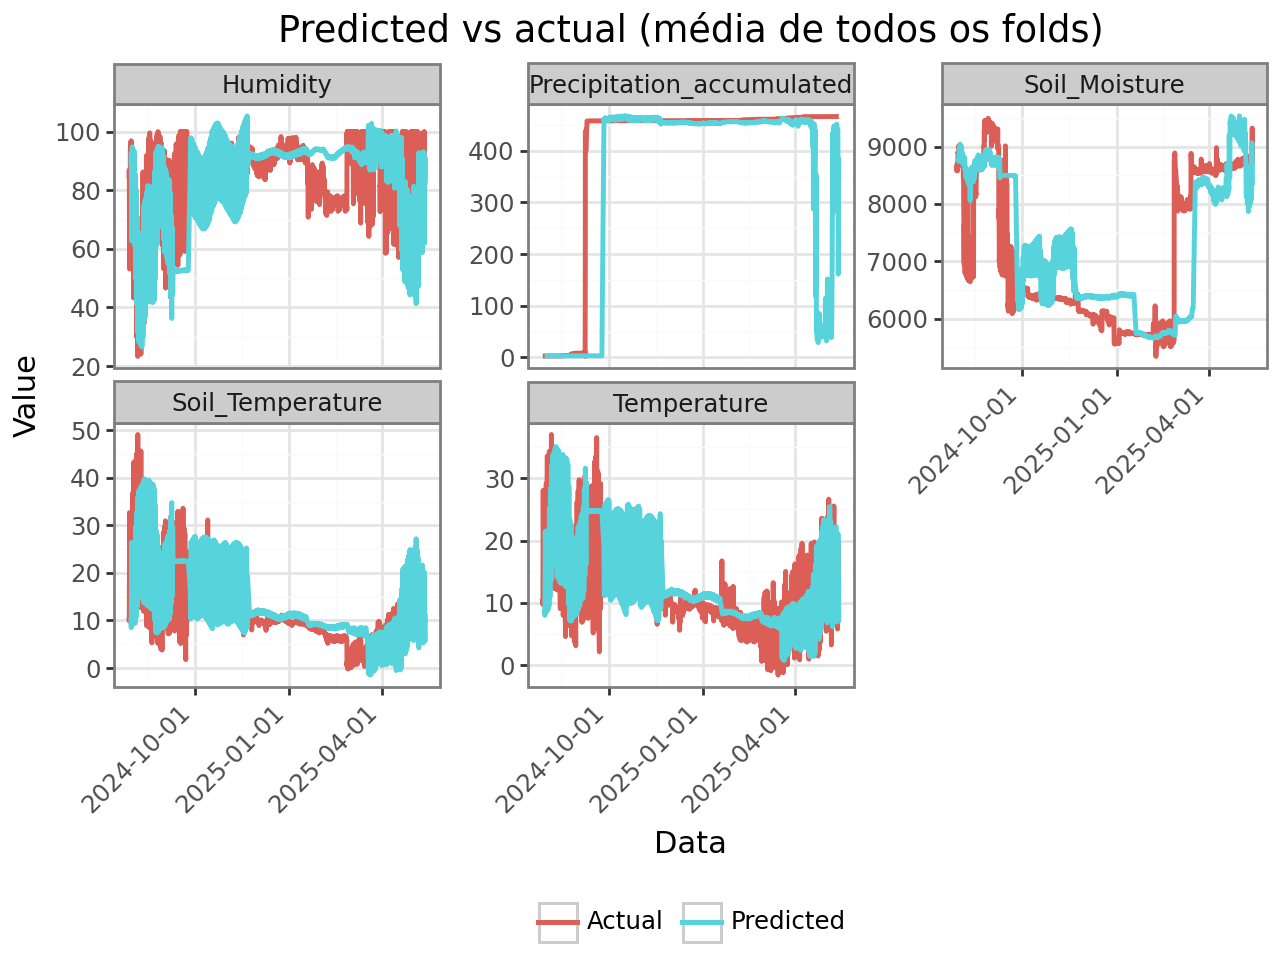

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_avg.png


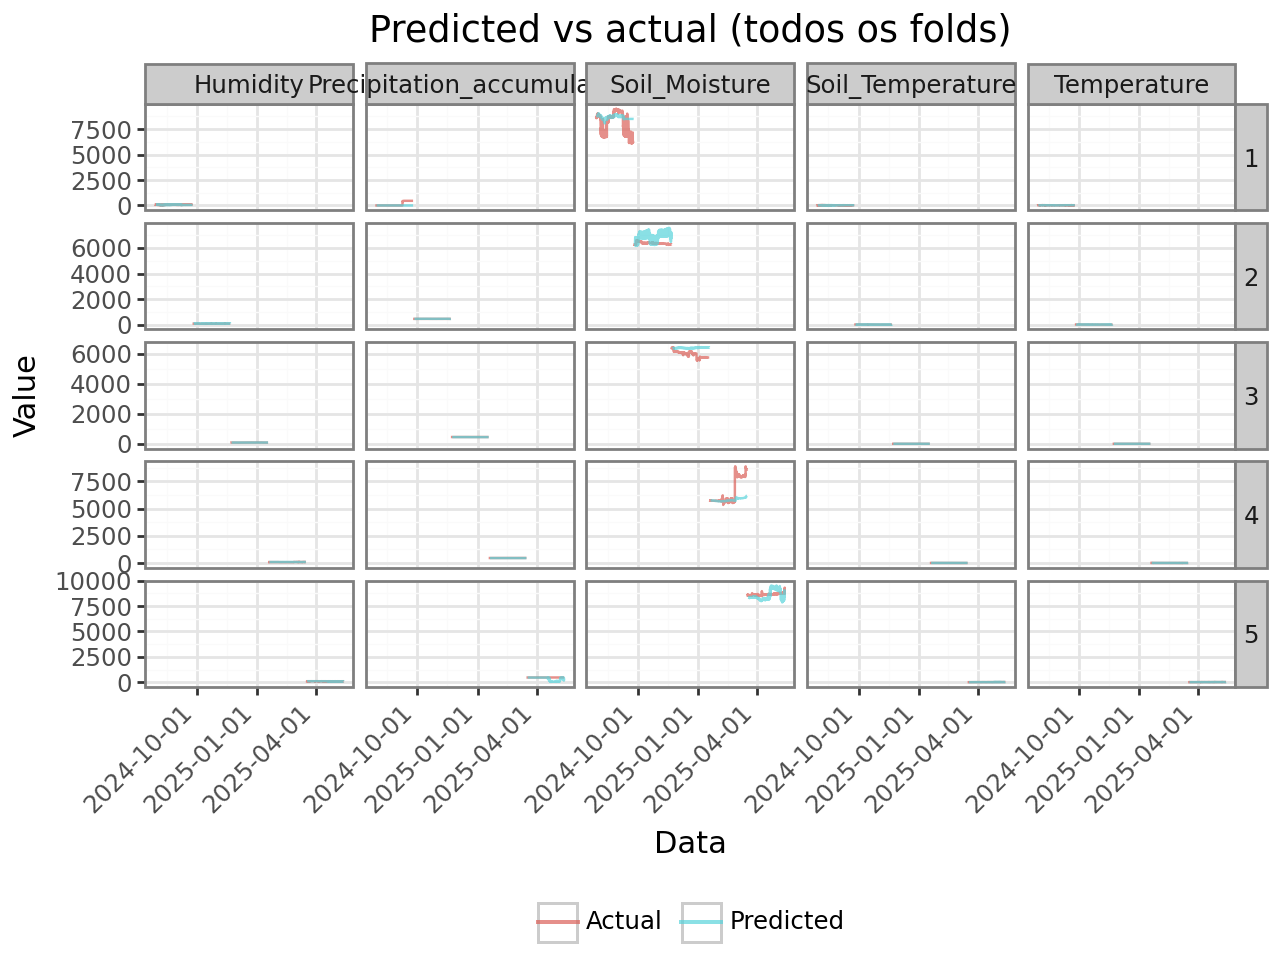

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 20 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_all_folds.png
/tmp/ipykernel_41828/688565223.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


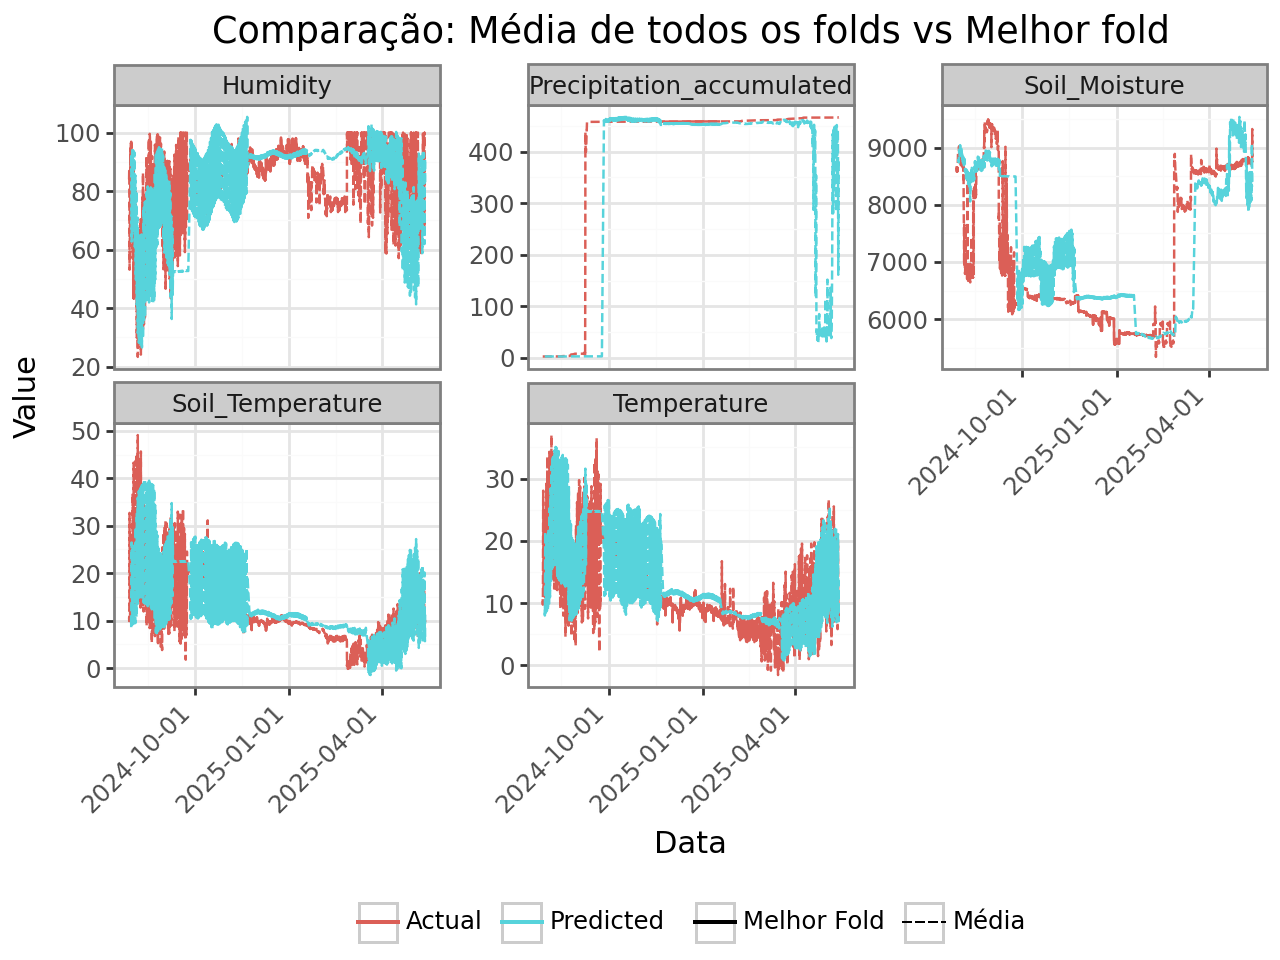

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_comparison.png


In [7]:
plot_columns = ['Timestamp', 'fold'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

# Também criar uma versão agregada (média) para cada target e timestamp
df_avg = df_combined.groupby(['Date', 'target_column', 'type']).agg({'value': 'mean'}).reset_index()
df_avg['fold'] = 'Média'

# Combinar os dados médios com os dados originais
df_all = pd.concat([df_combined, df_avg])

# Plot 1: Média de todos os folds
plot_avg = (
    ggplot(df_avg, aes(x='Date', y='value', color='type'))
    + geom_line(size=1)
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (média de todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_avg.show()
plot_avg.save('predict_actual_avg.png', width=12, height=10, dpi=300)

# Plot 2: Todos os folds separados por target
plot_all_folds = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line(alpha=0.7)
    + facet_grid('fold ~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        strip_text_y=element_text(angle=0)
    )
)
plot_all_folds.show()
plot_all_folds.save('predict_actual_all_folds.png', width=15, height=20, dpi=300)

# Plot 3: Comparação da média com o melhor fold
# Primeiro, preparar os dados do melhor fold
best_fold_data = df_combined[df_combined['fold'] == best_fold]
best_fold_data['fold'] = 'Melhor Fold'
comparison_data = pd.concat([df_avg, best_fold_data])

plot_comparison = (
    ggplot(comparison_data, aes(x='Date', y='value', color='type', linetype='fold'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Comparação: Média de todos os folds vs Melhor fold',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_comparison.show()
plot_comparison.save('predict_actual_comparison.png', width=12, height=10, dpi=300)

In [8]:
# Salvar métricas do melhor fold
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

# Salvar todas as métricas em um único arquivo
all_metrics = {
    'average': avg_metrics_df.to_dict(),
    'best_fold': best_metrics.to_dict(),
    'all_folds': {f'fold_{i+1}': df.to_dict() for i, df in enumerate(all_metrics_dfs)}
}
with open('all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)

print("\nAnálise completa! Os resultados foram salvos usando a média de todos os folds.")



Análise completa! Os resultados foram salvos usando a média de todos os folds.
